In [2]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Configurações
max_events = 10000
chunk_size = 500
LUMINOSITY = 30000  # 30 ab^-1 (FCC-hh)
    
# Arquivos
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file1 = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'
background_file2 = '/home/levi/Documentos/Sinal_background/background_pp_jjmumu.hepmc'

def calculate_event_weight(event_weight, cross_section, num_events):
    """Calcula o peso normalizado: weight × (σ × L / N)"""
    return event_weight * (cross_section * LUMINOSITY / num_events)

# Funções
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    """Versão única da função de leitura"""
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:
                yield events
                events = []
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()
        if events:
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        mean_displacement = np.mean(secondary_vertex_displacement)
        return mean_displacement > 1.0, mean_displacement  # Retorna se é b-tagged e a distância média
    return False, 0.0  # Retorna False e distância 0.0 se não houver vértices secundários

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para remover múons das partículas
def remove_muons(particles):
    return [p for p in particles if abs(p.pid) != 13]  # Múons têm PID ±13

# Função para identificar múons com cargas opostas e de mesmo sabor
def find_opposite_charge_muons(particles):
    muons = []
    for p in particles:
        if abs(p.pid) == 13:  # Múons têm PID ±13
            muons.append(p)
    
    # Selecionar pares de múons com cargas opostas
    muon_pairs = []
    for i in range(len(muons)):
        for j in range(i + 1, len(muons)):
            if muons[i].pid == -muons[j].pid:  # Cargas opostas
                muon_pairs.append((muons[i], muons[j]))
    
    return muon_pairs

# Função para calcular deltaR entre dois jatos
def delta_r(jet1, jet2):
    dphi = jet1.phi() - jet2.phi()
    deta = jet1.eta() - jet2.eta()
    return np.sqrt(dphi**2 + deta**2)

# Função para processar eventos e extrair informações
def extract_hepmc_metadata(hepmc_file):
    """Extrai seção de choque do arquivo HepMC"""
    with hep.open(hepmc_file) as f:
        for event in f:
            if hasattr(event, 'cross_section'):
                return {
                    'cross_section': float(event.cross_section.xsec()),
                    'cross_section_error': float(event.cross_section.xsec_err())
                }
    return {'cross_section': 1.0, 'cross_section_error': 0.0}

def extract_event_info(events, cross_section, num_events):
    data = []
    for event in events:
        # Peso bruto do evento (linha E ou N)
        event_weight = event.weights[0] if event.weights else 1.0
        
        # Peso físico normalizado
        weight = calculate_event_weight(event_weight, cross_section, num_events)
        
        # Partículas do evento com status 1 (partículas estáveis) e pT > 2 GeV
        particles = [p for p in event.particles if p.status == 1 and p.momentum.pt() > 2.0]
        
        # Identificar pares de múons com cargas opostas
        muon_pairs = find_opposite_charge_muons(particles)
        
        # Informações dos múons
        muon_info = {}
        if len(muon_pairs) >= 1:
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            muon1 = fj.PseudoJet(selected_pair[0].momentum.x, selected_pair[0].momentum.y, selected_pair[0].momentum.z, selected_pair[0].momentum.e)
            muon2 = fj.PseudoJet(selected_pair[1].momentum.x, selected_pair[1].momentum.y, selected_pair[1].momentum.z, selected_pair[1].momentum.e)
            muon_info['muon_mass'] = invariant_mass(muon1, muon2)
            muon_info['muon1_pt'] = muon1.pt()
            muon_info['muon2_pt'] = muon2.pt()
            muon_info['muon1_energy'] = muon1.e()
            muon_info['muon2_energy'] = muon2.e()
            muon_info['di_muon_energy'] = muon1.e() + muon2.e()
            muon_info['di_muon_pt'] = muon1.pt() + muon2.pt()
        else:
            muon_info['muon_mass'] = 0.0
            muon_info['muon1_pt'] = 0.0
            muon_info['muon2_pt'] = 0.0
            muon_info['muon1_energy'] = 0.0
            muon_info['muon2_energy'] = 0.0
            muon_info['di_muon_energy'] = 0.0
            muon_info['di_muon_pt'] = 0.0
        
        # Remover múons das partículas
        particles_no_muons = remove_muons(particles)
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles_no_muons]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Informações dos jatos
        jet_info = {}
        if len(jets) >= 2:
            b_jets = []
            b_tagged_distances = []
            for jet in jets:
                is_b_tagged_flag, b_tag_distance = is_b_tagged(jet, particles_no_muons)
                if is_b_tagged_flag:
                    b_jets.append(jet)
                    b_tagged_distances.append(b_tag_distance)
            
            if len(b_jets) >= 2:
                b_jets_sorted = sorted(b_jets, key=lambda j: j.pt(), reverse=True)
                b_jets_selected = b_jets_sorted[:2]
                jet_info['jet_mass'] = invariant_mass(b_jets_selected[0], b_jets_selected[1])
                jet_info['jet1_pt'] = b_jets_selected[0].pt()
                jet_info['jet2_pt'] = b_jets_selected[1].pt()
                jet_info['jet1_energy'] = b_jets_selected[0].e()
                jet_info['jet2_energy'] = b_jets_selected[1].e()
                jet_info['di_jet_energy'] = b_jets_selected[0].e() + b_jets_selected[1].e()
                jet_info['di_jet_pt'] = b_jets_selected[0].pt() + b_jets_selected[1].pt()
                jet_info['delta_r'] = delta_r(b_jets_selected[0], b_jets_selected[1])
                jet_info['num_jets'] = len(jets)
                jet_info['b_tag_distance1'] = b_tagged_distances[0]  # Distância de decaimento do primeiro jato b-tagged
                jet_info['b_tag_distance2'] = b_tagged_distances[1]  # Distância de decaimento do segundo jato b-tagged
            else:
                jet_info['jet_mass'] = 0.0
                jet_info['jet1_pt'] = 0.0
                jet_info['jet2_pt'] = 0.0
                jet_info['jet1_energy'] = 0.0
                jet_info['jet2_energy'] = 0.0
                jet_info['di_jet_energy'] = 0.0
                jet_info['di_jet_pt'] = 0.0
                jet_info['delta_r'] = 0.0
                jet_info['num_jets'] = len(jets)
                jet_info['b_tag_distance1'] = 0.0  # Distância de decaimento do primeiro jato b-tagged
                jet_info['b_tag_distance2'] = 0.0  # Distância de decaimento do segundo jato b-tagged
        else:
            jet_info['jet_mass'] = 0.0
            jet_info['jet1_pt'] = 0.0
            jet_info['jet2_pt'] = 0.0
            jet_info['jet1_energy'] = 0.0
            jet_info['jet2_energy'] = 0.0
            jet_info['di_jet_energy'] = 0.0
            jet_info['di_jet_pt'] = 0.0
            jet_info['delta_r'] = 0.0
            jet_info['num_jets'] = len(jets)
            jet_info['b_tag_distance1'] = 0.0  # Distância de decaimento do primeiro jato b-tagged
            jet_info['b_tag_distance2'] = 0.0  # Distância de decaimento do segundo jato b-tagged
        
        # Combinar informações
        event_info = {**muon_info, **jet_info, 'event_weight': weight}
        data.append(event_info)
    
    
    return pd.DataFrame(data)

print("\n[INFO] Processando eventos com pesos físicos...")

def process_samples(file_path, meta, label, max_events):
    """Processa arquivos com normalização"""
    chunks = []
    for chunk in read_hepmc_file_in_chunks(file_path, max_events):
        df = extract_event_info(chunk, meta['cross_section'], max_events)
        df['weight'] = df['event_weight'] * (meta['cross_section'] * LUMINOSITY / max_events)
        df['label'] = [label] * len(df)
        chunks.append(df)
    return pd.concat(chunks)

if __name__ == "__main__":
    # Extrai metadados
    sinal_meta = extract_hepmc_metadata(sinal_file)
    bg1_meta = extract_hepmc_metadata(background_file1)
    bg2_meta = extract_hepmc_metadata(background_file2)

    print("\n[INFO] Seções de choque encontradas (pb):")
    print(f"Sinal: {sinal_meta['cross_section']:.2e} ± {sinal_meta['cross_section_error']:.2e}")
    print(f"BG1: {bg1_meta['cross_section']:.2e} ± {bg1_meta['cross_section_error']:.2e}")
    print(f"BG2: {bg2_meta['cross_section']:.2e} ± {bg2_meta['cross_section_error']:.2e}")

    # Processa os eventos
    print("\n[INFO] Processando eventos...")
    signal_df = process_samples(sinal_file, sinal_meta, [1, 0, 0], max_events)
    background1_df = process_samples(background_file1, bg1_meta, [0, 1, 0], max_events)
    background2_df = process_samples(background_file2, bg2_meta, [0, 0, 1], max_events)



[INFO] Processando eventos com pesos físicos...

[INFO] Seções de choque encontradas (pb):
Sinal: 1.56e-07 ± 1.95e-04
BG1: 3.32e-04 ± 4.16e-01
BG2: 1.10e+00 ± 1.38e+03

[INFO] Processando eventos...
#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party 

In [3]:
import numpy as np

# Concatenar todos os DataFrames mantendo os pesos
full_df = pd.concat([signal_df, background1_df, background2_df])

# Extrair features, labels e pesos
features = full_df.drop(['label', 'event_weight', 'weight'], axis=1)  # Remove colunas não usadas como features
labels = np.array(full_df['label'].tolist())
weights = full_df['weight'].values  # Usamos os pesos já normalizados

# Verificação
print("\n[INFO] Formato dos dados:")
print(f"Features: {features.shape}")
print(f"Labels: {labels.shape}")
print(f"Pesos: {weights.shape}")
print(f"Exemplo de peso: {weights[0]:.2e}")


[INFO] Formato dos dados:
Features: (30000, 18)
Labels: (30000, 3)
Pesos: (30000,)
Exemplo de peso: 4.29e-17


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Dividir os dados mantendo a proporção de pesos
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    features, 
    labels, 
    weights,
    test_size=0.2,
    random_state=42,
    stratify=labels  # Mantém proporção das classes
)

# Normalização das features (importante para redes neurais)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Criação do modelo
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Treinamento com pesos
history = model.fit(
    X_train, 
    y_train,
    sample_weight=w_train,  # Incorpora os pesos
    epochs=150,
    batch_size=32,
    validation_data=(X_test, y_test, w_test),  # Pesos para validação
    verbose=1
)

/home/levi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-31 12:51:13.826675: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3398 - loss: 656.2729 - val_accuracy: 0.3333 - val_loss: 0.8417
Epoch 2/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3349 - loss: 0.5998 - val_accuracy: 0.3333 - val_loss: 0.1880
Epoch 3/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3295 - loss: 0.1467 - val_accuracy: 0.3333 - val_loss: 0.0722
Epoch 4/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3317 - loss: 0.0607 - val_accuracy: 0.3333 - val_loss: 0.0350
Epoch 5/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3329 - loss: 0.0341 - val_accuracy: 0.3333 - val_loss: 0.0192
Epoch 6/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3366 - loss: 0.0179 - val_accuracy: 0.3333 - val_loss: 0.0112
Epoch 7/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3328 - loss: 0.0149 - val_accuracy: 0.3333 - val_loss: 0.0068
Epoch 8/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3325 - loss: 0.0091 - val_ac

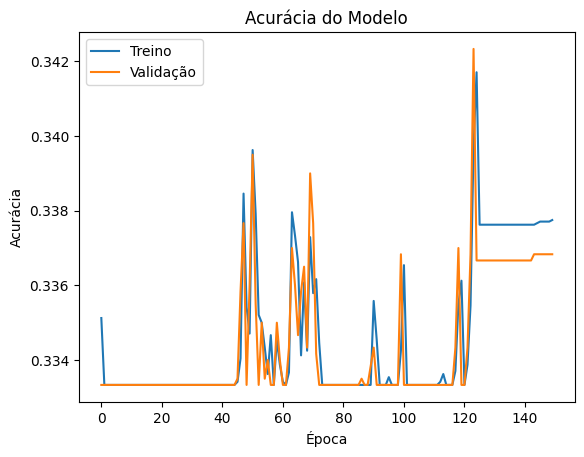

In [5]:
# Plota a acurácia durante o treinamento
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()

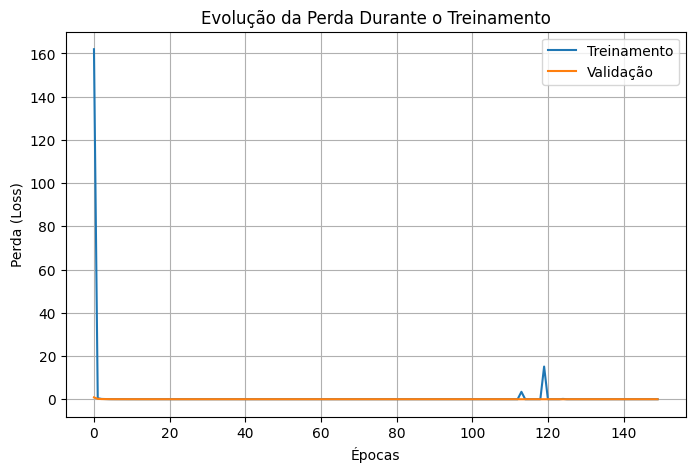

In [6]:
import matplotlib.pyplot as plt

# Plotar a curva de perda
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda (Loss)')
plt.title('Evolução da Perda Durante o Treinamento')
plt.legend()
plt.grid()
plt.show()

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


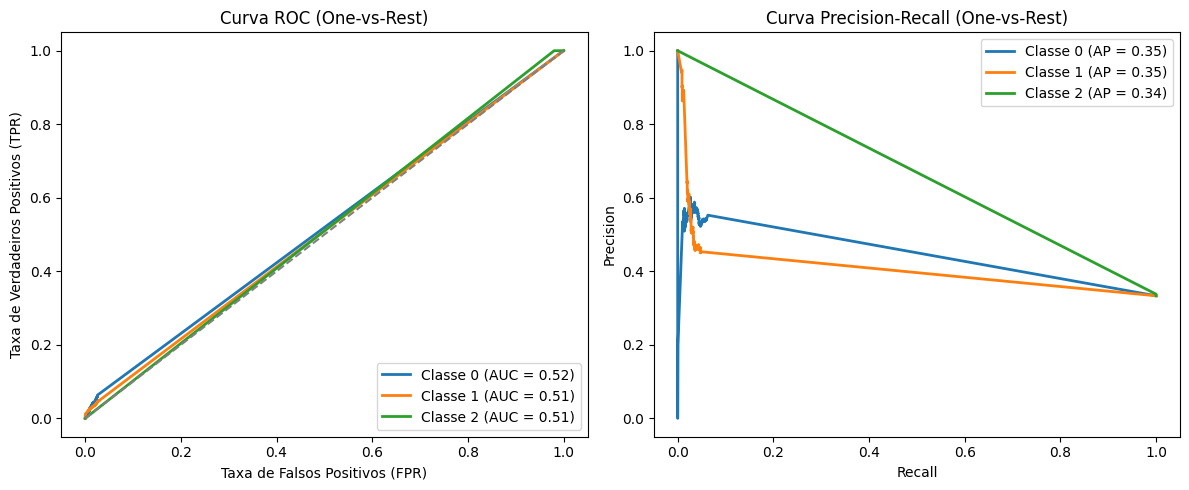

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# 1. Obter as probabilidades previstas para cada classe
y_scores = model.predict(X_test)  # Usar model.predict para obter as probabilidades

# 2. Converter y_test de one-hot para classes únicas (se necessário)
if y_test.ndim == 1:
    # y_test já está no formato de classes únicas
    y_test_classes = y_test
else:
    # Converter y_test de one-hot para classes únicas
    y_test_classes = np.argmax(y_test, axis=1)

# 3. Número de classes
n_classes = y_scores.shape[1]

# 4. Plotar as curvas ROC e Precision-Recall para cada classe
plt.figure(figsize=(12, 5))

# Curva ROC
plt.subplot(1, 2, 1)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_classes == i, y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Classe {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC (One-vs-Rest)')
plt.legend(loc='lower right')

# Curva Precision-Recall
plt.subplot(1, 2, 2)
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_classes == i, y_scores[:, i])
    average_precision = average_precision_score(y_test_classes == i, y_scores[:, i])
    plt.plot(recall, precision, lw=2, label=f'Classe {i} (AP = {average_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall (One-vs-Rest)')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


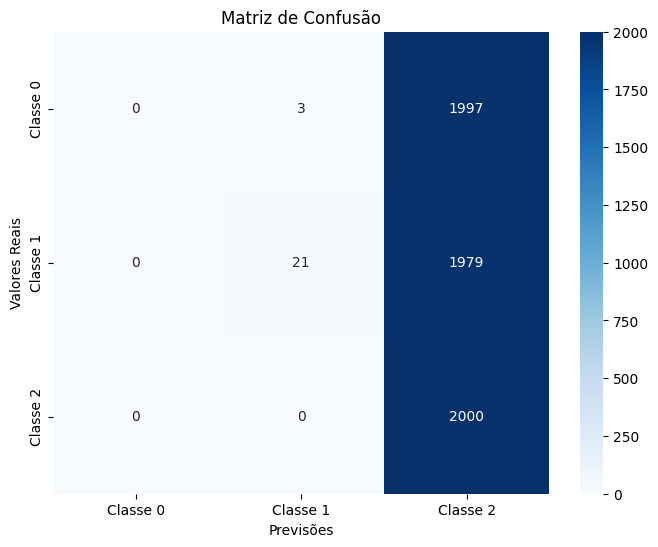

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Obter as previsões do modelo
y_pred = model.predict(X_test)  # Probabilidades para todas as classes
y_pred_classes = np.argmax(y_pred, axis=1)  # Converter probabilidades em classes preditas

# Verificar o formato de y_test
if y_test.ndim == 1:
    # y_test já está no formato de classes únicas
    y_test_classes = y_test
else:
    # Converter y_test de one-hot para classes únicas
    y_test_classes = np.argmax(y_test, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Classe 0', 'Classe 1', 'Classe 2'], 
            yticklabels=['Classe 0', 'Classe 1', 'Classe 2'])
plt.xlabel('Previsões')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão')
plt.show()